In [1]:
import mesa 
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Model_World import *

In [2]:
class EVAgent(mesa.Agent): 
    """ EVAgent objects represent electric vehicles which move with the model graph and may be in either a charging or driving state """ 
    
    def __init__(self, unique_id, model, inital_loc, trips, trip_lengths): 
        super().__init__(unique_id, model) 
        self.soc = 100 #state of charge, initalized to 100%
        self.amount_charged = 0 #sum of SOC that has been increased for this vehicle over the entire simulation
        self.elec_charge_price = 0 #sum of electricity price for charging vehicle 
    
        
        self.loc = inital_loc #inital node location
        self.trips = trips #list of nodes to travel to
        self.trip_lengths = trip_lengths #list of how long to stay at each node 
        self.current_trip_length = trip_lengths[0] #how many ticks to stay at current node
        
        self.on_trip = True #indicator for being in driving state
        self.trip_start = 0 #tick when trip begins
        
        self.current_charger_objs = []  #list of all the chargers at the current node
        self.in_queue = False
        self.plugged_in = False #indicator for having been assigend a charger and charging
        self.charging = False #indicator for being in parked state
        self.charging_start = None #tick when charging begins 
        self.charger_used = None #the assigned charger object when charging
        
        self.trips_completed = 0
        self.no_charge_count = 0
        
    
    def take_trip(self): 
        """ This function executes the trip (driving) state. When a EV agent has been in the trip state for the length of the trip, complete the trip."""
            
        if self.model._current_tick - self.trip_start >= self.model.G.get_edge_data(self.loc,self.trips[0])["weight"]: 
            #if enough ticks have passed to complete trip (given by edge weight) 
            if flag:
                print("*****") 
                print("trip complete")
                print("drive distance", self.model.G.get_edge_data(self.loc,self.trips[0])["weight"])
                print("trip_list" , self.trips)
                print("trip_length", self.trip_lengths)
                print("current trip length", self.current_trip_length)
                print("*****") 
            
            self.on_trip = False
            #update attributes for completed trip    
            
            self.soc -= (self.model.G.get_edge_data(self.loc,self.trips[0])["weight"] * 20) / 474  
            # 20 km / tick * edge weight (ticks) = (km  traveled) 
            # Km traveled / range =  % discharge 
            
            self.trips_completed += 1
            self.loc = self.trips[0] #update location for new node
            self.current_trip_length = self.trip_lengths[0]
            self.trips = self.trips[1:]
            self.trip_lengths = self.trip_lengths[1:]
            self.model.grid.move_agent(self, self.loc)  #update position on grid 
   
            #switch to charging state
            self.charging = True
            self.charging_start = self.model._current_tick
            
    def increase_charge(self):
        """ Called each tick when a vehicle is charging
            updates SOC and total amount charged based on charger speed
            updates cost of charging """ 
        
        #determine rate based on charger type 
        if self.charger_used.charger_type == "fast": 
            charge_per_tick = self.model.fast_charging_rate
        elif self.charger_used.charger_type == "slow": 
            charge_per_tick = self.model.slow_charging_rate 
        elif self.charger_used.charger_type == "home":
            charge_per_tick = self.model.home_charging_rate 

        #increase soc by charge_per_tick unless fully charged 
        temp = self.soc
        self.soc = min(self.soc + charge_per_tick, 100) #dont allow charge above 100% 
        self.amount_charged += self.soc - temp
        
        #update cost of charging
        if self.charger_used.charger_type == "slow": 
            self.elec_charge_price += self.model.elec_price * 3.7 #7.4 KW charger for a slow charger, so for each tick 3.7 KW energy is used
        if self.charger_used.charger_type == "fast": 
            self.elec_charge_price += self.model.elec_price * 11 #22 KW charger for a slow charger, so for each tick 11 KW energy is used

            
    def charge(self): 
        """ This function executes the charging state. EV agents in this state may either charge and occupy a charger, or if all chargers are in use then it will 
        wait in the queue at that node"""
        
        try:
            self.current_charger_objs = self.model.charger_loc[self.loc]
        except: 
            self.current_charger_objs = []  
        
        if self.current_charger_objs != []: #if there are one or more chargers at this location
            for charger in self.current_charger_objs: #iterate through chargers at this node
                if self.model.charger_queue[self.loc] == [] or self.plugged_in: #if there are no cars in the queue
                    if charger.car_charging == None or charger.car_charging == self.unique_id: #if no other cars at this charger
                        #begin charging
                        self.charger_used = charger
                        charger.car_charging = self.unique_id #state that this car is at the given charger
                        self.plugged_in = True 
                        
                        self.increase_charge() #increase charge
                        break
                
                #if there is a queue at the charger, check if you are first in line. if first, then remove from queue and start charging. if not dont charge
                else: #there is a queue
                    if self.model.charger_queue[self.loc][0] == self.unique_id: #if you are first in line
                        if charger.car_charging == None: #no other cars occupying this charger
                            #begin charging
                            self.model.charger_queue[self.loc] = self.model.charger_queue[self.loc][1:] #remove yourself from queue 
                            self.in_queue = False
                            charger.car_charging = self.unique_id #start charging
                            self.plugged_in = True
                            self.charger_used = charger
                            break
                
            
            #if after interating through all the chargers you have not been assigned a charger, add yourself to queue
            if not self.plugged_in: 
                if self.unique_id not in self.model.charger_queue[self.loc]: #if not already in queue
                    self.model.charger_queue[self.loc].append(self.unique_id) 
                    self.in_queue = True

        #LEAVING THE CHARGING STATION
        if self.model._current_tick - self.charging_start >= self.current_trip_length: # if have been at charging station for trip length
            #begin trip if you have sufficient charge for the next edge 
            if self.soc > (self.model.G.get_edge_data(self.loc,self.trips[0])["weight"] * 20) / 474: 
                self.charging = False
                self.plugged_in = False
                self.on_trip = True #switch to trip
                if self.charger_used != None: #if EV agent was occupying a charger, leave
                    self.charger_used.car_charging = None 
                    
                if self.in_queue: #if EV agent was in the queue, leave
                    self.model.charger_queue[self.loc] = [i for i in self.model.charger_queue[self.loc] if i != self.unique_id]  
                    self.in_queue = False
                
                self.trip_start = self.model._current_tick #update tick in which trip begins
                
            else: #do not have enough charge to begin the next trip, stay in charging state 
                self.charging = True
                self.no_charge_count += 1
                
        
    def step(self):     
        if self.charging: 
            self.charge()
        if self.on_trip: 
            self.take_trip()
        
        if flag: 
            print("\n")
            print("EV number",self.unique_id)
            print("Location", self.loc)
            print("car soc", self.soc)
            print("trip list", self.trips) 
            print("trip lenghts", self.trip_lengths)
            
            print("plugged in", self.plugged_in) 
            print("charging", self.charging)

            print("on trip", self.on_trip)
        


In [3]:
class Charger(mesa.Model): 
    """  Charger objects track the cars at the given station""" 
    
    def __init__(self,unique_id, model,node_loc, charger_type): 
        super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.node_loc = node_loc
        self.car_charging = None
        self.charger_type = charger_type #fast or slow
             
    def step(self): 
        pass

In [4]:
class EVCSModel(mesa.Model): 
    """ EV Charging Station Model uses an agent based approach. EV agent and chargers are placed throughout a graph defined by Model_World.py 
    
    EV agents move between nodes in the network according to a randomly generated "trip list". At each node, EV agents may charge if a charger is present 
    that is not in use by another agent. If the charger is in use, then the EV agent joins the charger queue at that node.
    
    Time steps is discretized in the model by defined "ticks", where 1 tick = 30 minutes. EV agents execute charging, waiting in the queue,
    or travel at each time step. 
    
    Key data about EV movements is collected. 

    """ 
    def __init__(self, no_agents,no_chargers,charger_placement, no_ticks, G, trip_lists, no_fast, charge_rates, scenario, day_ahead_df):
        self.ticks = no_ticks
        self._current_tick = 0
        
        self.no_agents = no_agents
        self.no_chargers = no_chargers
        self.no_fast = no_fast
        self.fast_charging_rate = charge_rates[0]
        self.slow_charging_rate = charge_rates[1]
        self.home_charging_rate = charge_rates[2]
        self.scenario = scenario

        self.agents = []
        self.chargers = []
        self.charger_queue = {} #key = node, value = list of car id's in queue at that node
        self.charger_loc = {} #key = node, value = charger id at that node 
        
        self.schedule = mesa.time.BaseScheduler(self)
        self.elec_price = float(day_ahead_df[day_ahead_df['tick'] == self._current_tick]["Price KWh"]) #price is given as euro/KWh
        
        self.G = G
        self.grid = NetworkGrid(self.G)
    
        self.datacollector = DataCollector(model_reporters={'Average Charge Level': get_average_soc,
                                                            'Average EV Trips Complete': get_trips_completed, 
                                                            "Amount Charged": get_amount_charged, 
                                                           "Instances of Insufficient Charge": get_insufficient_charge_count, 
                                                           "Length of Queue": get_number_in_queue,
                                                            "NEW lenght of queue": get_number_in_queue_NEW, 
                                                           "Electricity cost (euro)": get_elec_cost, 
                                                           "Total cost": get_total_cost, 
                                                           "Utility": get_utility})
        
        #Generate EV agents 
        for i in range(self.no_agents): 
            a = EVAgent(unique_id = i, model =self, inital_loc = trip_lists[i][0][0], trips = trip_lists[i][0][1:], trip_lengths = trip_lists[i][1][1:])
            self.grid.place_agent(a, i)
            self.agents.append(a)
            self.schedule.add(a)
            
        #Generate charger agents and queue 
        fast_charger_nodes = random.sample(self.G.total_nodes, self.no_fast)
        
        for i in range(self.no_chargers): 
            if self.scenario == 1: #assignment of charger types according to scenario 1
                if i <= self.no_homes:
                    charger_type = "home"
                elif i >= self.no_homes and i <= self.no_homes + self.no_fast: 
                    charger_type = "fast"
                else: 
                    charger_type = "slow"
                    
            else: #assignment of charger types according to scenario 2
                #randomly assign fast or slow chargers
                if i in fast_charger_nodes: 
                    charger_type = "fast"
                else: 
                    charger_type = "slow"
            
            c = Charger(unique_id = i, model = self ,node_loc =charger_placement[i], charger_type = charger_type)
            self.chargers.append(c)
            
            if charger_placement[i] not in self.charger_queue.keys(): 
                self.charger_queue[charger_placement[i]] = [] 
                
            if charger_placement[i] not in self.charger_loc.keys(): 
                self.charger_loc[charger_placement[i]] = [c]
                
            else: 
                self.charger_loc[charger_placement[i]].append(c)
            
        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self._current_tick += 1
        #print("PRICE !!!!!!!!!!!!!!!!", self.elec_price)
        if flag: 
            print("CURRENT TICK" , self._current_tick)
            print("__________________________")
        
        # print("current tick", self._current_tick)
        # print("charger queue", self.charger_queue) 
        # queue_length = np.sum([1 for agent in model.agents if agent.in_queue])
        # print(" ************** lenght of queue",queue_length)

In [14]:
#Define functions for data collection
def get_average_soc(model):
    ev_soc = [agent.soc for agent in model.agents] 
    return np.mean(ev_soc) 

def get_trips_completed(model):  
    ev_trips_completed = [agent.trips_completed for agent in model.agents] 
    return np.sum(ev_trips_completed)

def get_amount_charged(model): 
    ev_amount_charged = [agent.amount_charged for agent in model.agents] 
    return np.sum(ev_amount_charged)

def get_insufficient_charge_count(model): 
    count = [agent.no_charge_count for agent in model.agents] 
    return np.sum(count)          

def get_number_in_queue(model): 
    count = [1 for agent in model.agents if agent.in_queue] 
    return np.sum(count)

def get_number_in_queue_NEW(model): 
    count = 0
    for node in model.charger_queue.keys(): 
        count += len(model.charger_queue[node])
    return count

def get_elec_cost(model): 
    count = [agent.elec_charge_price for agent in model.agents] 
    return np.sum(count)

def get_total_cost(model): 
    """Used to define optimization obj function
        Cost is defined as sum of price per charging station (slow and fast)
        Price of electricity used"""    
    fast = 28401
    slow = 1182
    home = 813
    
    if model.scenario == 1: 
        evcs_fast_cost = model.no_fast * fast 
        evcs_slow_cost = (model.no_chargers - model.no_fast - model.no_homes) * slow 
        evcs_home_cost = model.no_homes * home
        
    elif model.scenario == 2: 
        #TODO 
        pass 

    cost = get_elec_cost(model) + evcs_fast_cost + evcs_slow_cost + evcs_home_cost
    return cost

def get_utility(model): 
    """ measure of benefit gained from charging. Increased for each completed trip, penalties for cases of insufficient charge, penalties for long queue""" 
    alpha = 0.3
    beta = 0.3
    gamma = 0.3
    utility = (alpha * get_trips_completed(model)) - (beta * get_insufficient_charge_count(model)) - (gamma * get_number_in_queue(model)) 
    
    return utility - get_total_cost(model)

    

In [15]:
#import day-ahead electricy price
df = pd.read_csv("Oct_2019_day_ahead.csv")
day_ahead_df = pd.DataFrame(np.repeat(df.values, 2, axis=0))
day_ahead_df.columns = df.columns
day_ahead_df["tick"] = [i for i in range(day_ahead_df.shape[0])]

In [19]:
#import model inputs
input_df = pd.read_csv("Model_Inputs.csv")

In [ ]:
input_df.columns

Index(['Variable', 'Value'], dtype='object')

### Test run of EVCS model

In [ ]:
Model_World = Model_World(no_homes = no_homes, no_work = no_work, no_stores = no_stores, no_ticks = no_ticks)

In [16]:
#test 
#Baseline model inputs
charge_per_tick = 10
discharge_factor = 30


flag = False

no_homes = 10
no_agents = no_homes
no_work = 2
no_stores = 3
no_chargers = 30
no_fast = 20

charge_rates = (26.3, 3.47, 0.7) #(fast charger rate, slow charger rate, home charger rate) NEED TO CONVERT THIS TO THE SOC INCREASE PER TICK

scenario = 1
n = no_chargers - no_homes 
no_ticks = 20 # one month = 48 * 7 * 4


MW = Model_World(no_homes = no_homes, no_work = no_work, no_stores = no_stores, no_ticks = no_ticks)
Model_Graph = MW.G 

trip_lists = MW.get_trip_lists()
charger_placement = MW.get_charger_placement(scenario, int(n))

#trip_lists = {0: ([0, 10, 13], [22, 19, 6]), 1: ([1, 11, 12], [27, 18, 7]), 2: ([2, 10, 12], [19, 20, 8]), 3: ([3, 10, 14], [26, 19, 7]), 4: ([4, 11, 12], [27, 16, 6]), 5: ([5, 10, 12], [28, 20, 7]), 6: ([6, 10, 13], [22, 20, 5]), 7: ([7, 11, 13], [16, 19, 8]), 8: ([8, 11, 13], [28, 16, 6]), 9: ([9, 11, 13], [16, 17, 8])}
#charger_placement = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 11, 11, 11, 11]


#charger_placement = [0, 1, 2, 3, 4, 5, 5, 5, 5]

model = EVCSModel(no_agents=no_agents, no_chargers=no_chargers, charger_placement =charger_placement, no_ticks = no_ticks,
                  G=Model_Graph, trip_lists = trip_lists, no_fast = no_fast, charge_rates  = charge_rates, day_ahead_df = day_ahead_df)

for _ in range(no_ticks):
    model.step()

data_collection = model.datacollector.get_model_vars_dataframe()


In [17]:
data_collection

,Average Charge Level,Average EV Trips Complete,Amount Charged,Instances of Insufficient Charge,Length of Queue,NEW lenght of queue,Electricity cost (euro),Total cost,Utility
0,100.00,0,0.0,0,0.0,0,0.000000,25000.000000,-25000.000000
1,96.67,2,0.0,0,0.0,0,0.000000,25000.000000,-24999.400000
2,70.51,8,29.1,0,1.0,1,0.363990,25000.363990,-24998.263990
3,70.18,10,187.8,0,2.0,2,2.064816,25002.064816,-24999.664816
4,76.04,10,246.4,0,4.0,4,3.765642,25003.765642,-25001.965642
5,78.01,10,266.1,0,4.0,4,5.466468,25005.466468,-25003.666468
6,78.01,10,266.1,0,4.0,4,7.167294,25007.167294,-25005.367294
7,78.01,10,266.1,0,4.0,4,8.868120,25008.868120,-25007.068120
8,78.01,10,266.1,0,4.0,4,10.568946,25010.568946,-25008.768946
9,78.01,10,266.1,0,4.0,4,12.269772,25012.269772,-25010.469772


In [150]:
print(data_collection.max())
print("\n")
print(data_collection.mean())

Average Charge Level                100.0
Average EV Trips Complete             1.3
Amount Charged                      404.1
Instances of Insufficient Charge      0.0
Length of Queue                       1.0
NEW lenght of queue                   1.0
dtype: float64


Average Charge Level                 85.5065
Average EV Trips Complete             0.9100
Amount Charged                      275.5750
Instances of Insufficient Charge      0.0000
Length of Queue                       0.7500
NEW lenght of queue                   0.7500
dtype: float64


#### Generate figures for single test run

In [22]:
def run_model(discharge_factor, no_homes, no_chargers, no_work, no_stores, scenario, no_ticks, no_fast, charge_rates, day_ahead_df):
    """ runs the model for defined inputs and returns collected data as a pandas df""" 
    
    scenario = inp
    
    if scenario == 1:
        n = no_chargers - no_homes 
    if scenario == 2: 
        n = no_chargers
        
    no_agents = no_homes  #note that number of homes = number of EV agents (one agent per household)
    edge_weight_ranges = {"home_to_work": 3, "work_to_store": 0, "store_to_home": 2} #input factors to generate the edge weights 


    MW = Model_World(no_homes = no_homes, no_work = no_work, no_stores = no_stores, no_ticks = no_ticks, edge_weight_ranges = edge_weight_ranges)
    Model_Graph = MW.G 
    trip_lists = MW.get_trip_lists()
    charger_placement = MW.get_charger_placement(scenario, int(n))
    model = EVCSModel(no_agents=no_agents, no_chargers=no_chargers, charger_placement =charger_placement, no_ticks = no_ticks,
                  G=Model_Graph, trip_lists = trip_lists, no_fast = no_fast, charge_rates  = charge_rates, day_ahead_df = day_ahead_df)   
    
    for _ in range(no_ticks):
        model.step()
    
    data_collection = model.datacollector.get_model_vars_dataframe()

    return data_collection

In [19]:
def create_figures(data_collection): 
    """plots data collection values against the ticks for a single model run """
    for value in data_collection.columns:
        plt.figure(figsize=(8, 5))
        plt.plot(data_collection[value])
        plt.xlabel("Tick")
        plt.ylabel(str(value))
        plt.title(str(value) + " over time")
        plt.show()

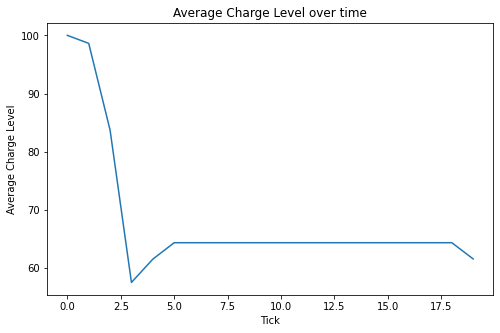

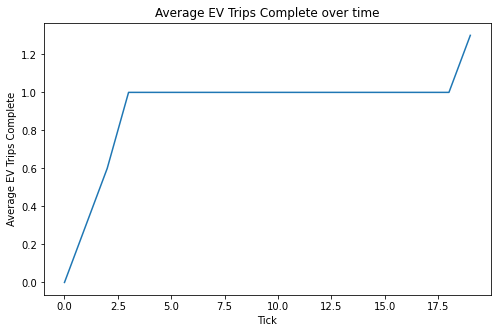

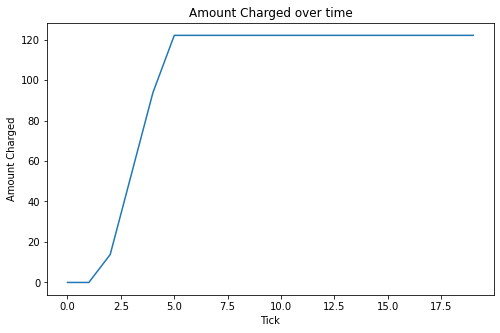

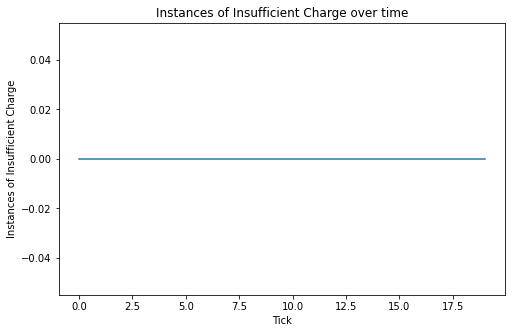

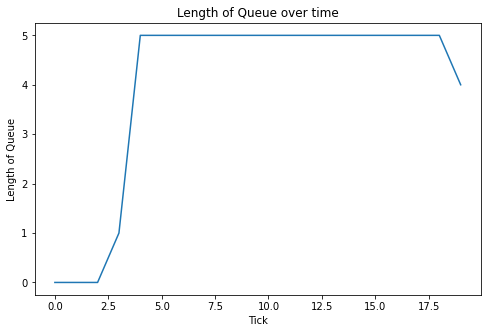

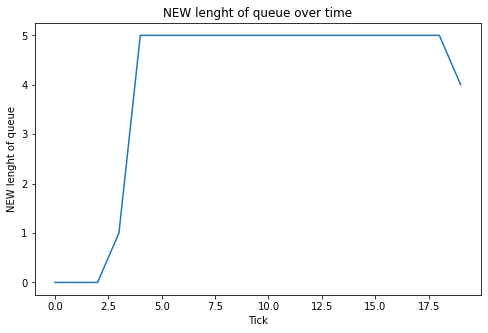

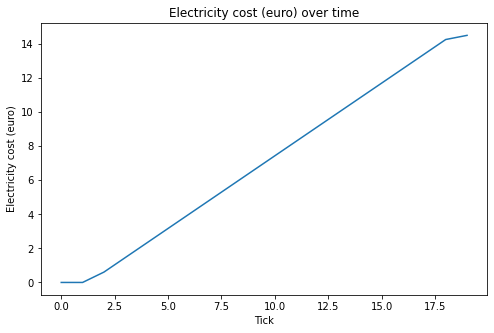

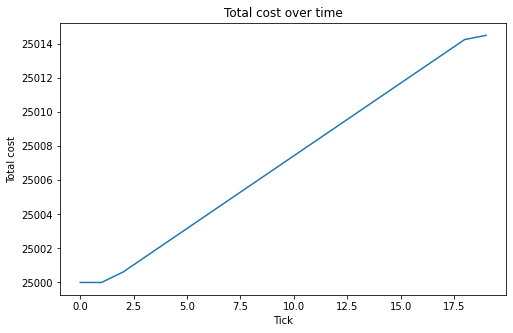

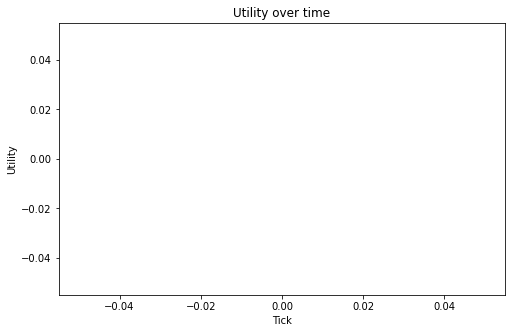

In [21]:
charge_per_tick = 10
discharge_factor = 30
flag = False

no_homes = 10
no_agents = no_homes
no_work = 2
no_stores = 3
no_chargers = 30
no_fast = 20

charge_rates = (40, 20) #(fast charger rate, slow charger rate) 

scenario = 1
n = no_chargers - no_homes 
no_ticks = 20 # one month = 48 * 7 * 4

data_collection = run_model(discharge_factor, no_homes, no_chargers, no_work, no_stores, scenario, no_ticks, no_fast, charge_rates, day_ahead_df)
create_figures(data_collection)

#### Sensitivity Analysis: Run model repeatedly with varied inputs and plot affect

In [33]:
#Baseline model inputs
fast_charging_rate = 40
slow_charging_rate = 10



discharge_factor = 30
flag = False

no_homes = 100
no_work = 20
no_stores = 30
no_chargers = 125
no_fast = 20

scenario = 2
no_ticks = 1344 # one month = 48 * 7 * 4

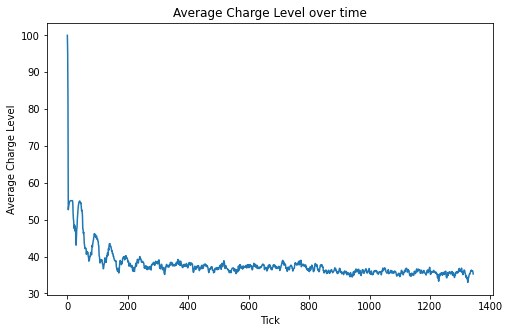

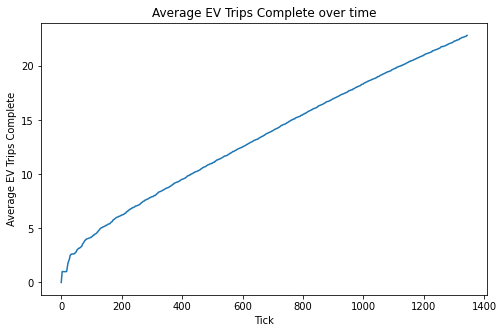

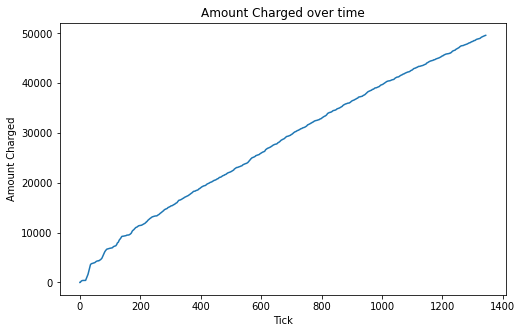

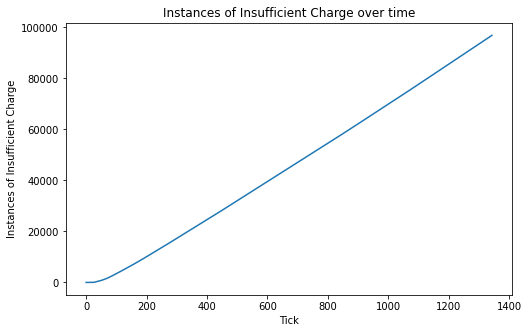

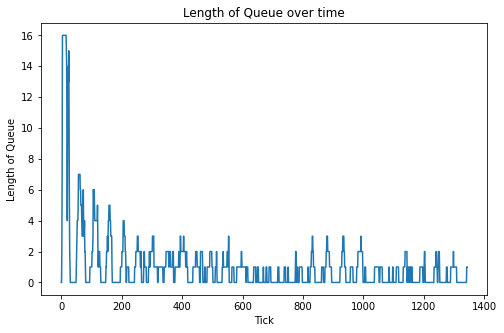

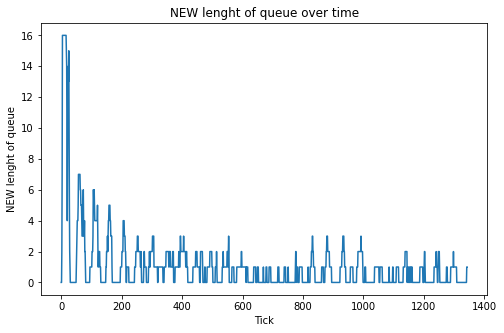

In [37]:
data_collection = run_model(discharge_factor, no_homes, no_chargers, no_work, no_stores, scenario, no_ticks, no_fast)
create_figures(data_collection) 

In [38]:
data_collection

,Average Charge Level,Average EV Trips Complete,Amount Charged,Instances of Insufficient Charge,Length of Queue,NEW lenght of queue
0,100.000,0.00,0.0,0,0.0,0
1,95.251,0.30,0.0,0,0.0,0
2,82.820,0.59,82.0,0,2.0,2
3,52.718,1.00,154.3,0,7.0,7
4,53.479,1.00,230.4,0,16.0,16
...,...,...,...,...,...,...
1339,36.052,22.78,49508.4,96572,0.0,0
1340,36.153,22.79,49528.4,96651,0.0,0
1341,36.152,22.80,49558.3,96730,0.0,0
1342,35.914,22.83,49578.3,96809,1.0,1


In [10]:
#data_collection["Length of queue"].mean()

In [11]:
#data_collection["Length of queue"]

In [12]:
#data_collection["NEW lenght of queue"]

In [18]:
data_collection.mean()

Average SOC                            48.647992
EV trips complete                      21.267083
Amount charged                      50486.049628
Instances of Insufficient Charge    32092.809524
Length of queue                         4.464286
NEW lenght of queue                     4.464286
dtype: float64

In [12]:
data_collection.max()

Average SOC                            100.0
EV trips complete                     6575.0
Amount charged                      176669.7
Instances of Insufficient Charge     24987.0
Length of queue                         46.0
NEW lenght of queue                     46.0
dtype: float64

In [39]:
def plot_sensitivity_analysis(item, df): 
    for value in df.columns:
        plt.figure(figsize=(8, 5))
        
        scenario_1 = df[df["Scenario"] == 1]
        scenario_2 = df[df["Scenario"] == 2]
        
        plt.plot(scenario_1[item],scenario_1[value], label = "Scenario 1")
        plt.plot(scenario_2[item], scenario_2[value],label = "Scenario 2")
        plt.legend()
        plt.xlabel(item)
        plt.ylabel(str(value))
        plt.title("Impact of " + item + " on " + str(value))
        plt.show()
        # plt.savefig(item + "_on_" + str(value) + '.png')

In [43]:
#Vary number of Chargers
number_chargers = np.linspace(50, 300, 11) 
no_homes = 100

columns = ['Average Charge Level', 'Average EV Trips Complete', 'Amount Charged', 'Instances of Insufficient Charge', 'Length of Queue']
data = {item:[] for item in columns}  
data["Number of Chargers"] = []
data["Scenario"] = []
                      
for no_chargers in number_chargers: 
    for scenario in [1,2]:
        data_collection = run_model(discharge_factor, no_homes, int(no_chargers), no_work, no_stores, scenario, no_ticks, no_fast)
        data["Scenario"].append(scenario)   
        data["Number of Chargers"].append(no_chargers)
        data['Average Charge Level'].append(data_collection["Average Charge Level"].mean())
        data['Average EV Trips Complete'].append(data_collection['Average EV Trips Complete'].max())
        data["Amount Charged"].append(data_collection["Amount Charged"].max())
        data["Instances of Insufficient Charge"].append(data_collection["Instances of Insufficient Charge"].max())
        data["Length of Queue"].append(data_collection["Length of Queue"].mean())
    
    
df = pd.DataFrame(data)

In [ ]:
plot_sensitivity_analysis("Number of Chargers", df)

In [19]:
#Vary number of homes (agents)
no_chargers = 125

number_homes = np.linspace(10,100, 10) 
columns = ['Average Charge Level', 'Average EV Trips Complete', 'Amount Charged', 'Instances of Insufficient Charge', 'Length of Queue']
data = {item:[] for item in columns}  
data["Number of EV agents"] = []
data["Scenario"] = []
                      
for no_homes in number_homes: 
    for scenario in [1,2]:
        data_collection = run_model(discharge_factor, int(no_homes), no_chargers, no_work, no_stores, scenario, no_ticks)
        data["Scenario"].append(scenario)   
        data["Number of EV agents"].append(no_homes)
        data['Average Charge Level'].append(data_collection["Average Charge Level"].mean())
        data['Average EV Trips Complete'].append(data_collection['Average EV Trips Complete'].max())
        data["Amount Charged"].append(data_collection["Amount Charged"].max())
        data["Instances of Insufficient Charge"].append(data_collection["Instances of Insufficient Charge"].max())
        data["Length of Queue"].append(data_collection["Length of Queue"].mean())
    
    
df = pd.DataFrame(data)

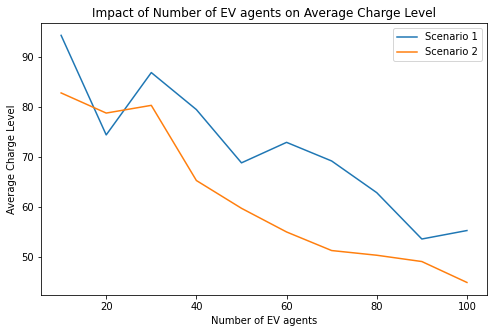

<Figure size 432x288 with 0 Axes>

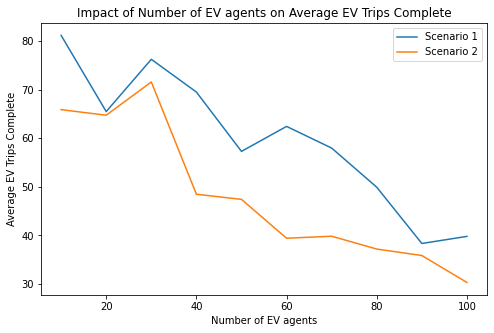

<Figure size 432x288 with 0 Axes>

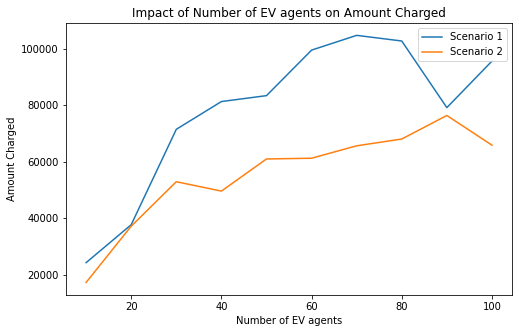

<Figure size 432x288 with 0 Axes>

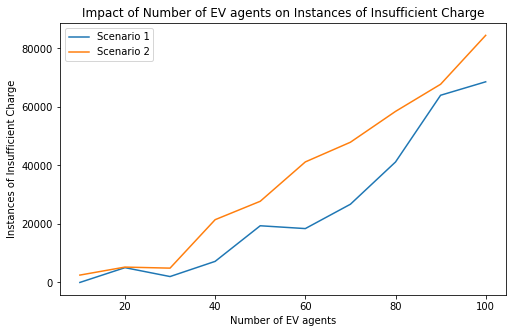

<Figure size 432x288 with 0 Axes>

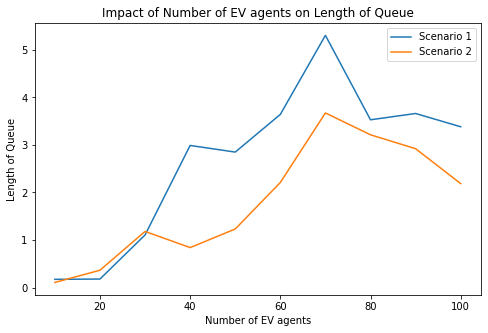

<Figure size 432x288 with 0 Axes>

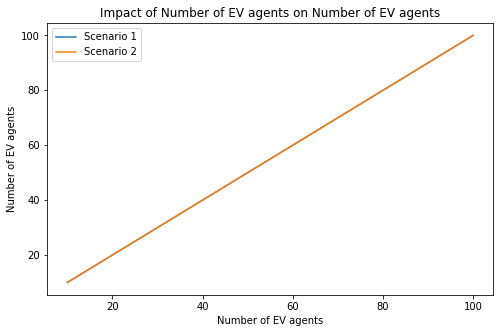

<Figure size 432x288 with 0 Axes>

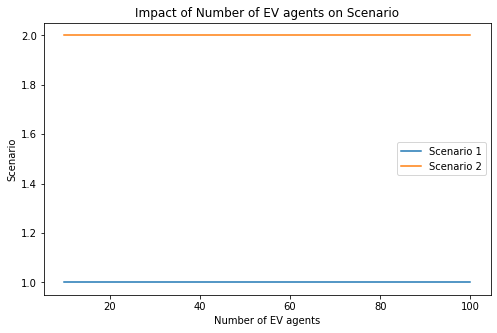

<Figure size 432x288 with 0 Axes>

In [20]:
plot_sensitivity_analysis("Number of EV agents", df)

In [21]:
#Vary charging rate
discharge_factor = 30

no_homes = 50
no_work = 5
no_stores = 10
no_chargers = 55

scenario = 1
no_ticks = 336

charge_rate = np.linspace(5,35, 7) 

columns = ['Average Charge Level', 'Average EV Trips Complete', 'Amount Charged', 'Instances of Insufficient Charge', 'Length of Queue']
data = {item:[] for item in columns}  
data["Charge Rate"] = []
data["Scenario"] = []
                      
for charge_per_tick in charge_rate: 
    for scenario in [1,2]:
        data_collection = run_model(int(charge_per_tick), discharge_factor, no_homes, no_chargers, no_work, no_stores, scenario, no_ticks)
        data["Scenario"].append(scenario)   
        data["Charge Rate"].append(charge_per_tick)
        data['Average Charge Level'].append(data_collection["Average Charge Level"].mean())
        data['Average EV Trips Complete'].append(data_collection['Average EV Trips Complete'].max())
        data["Amount Charged"].append(data_collection["Amount Charged"].max())
        data["Instances of Insufficient Charge"].append(data_collection["Instances of Insufficient Charge"].max())
        data["Length of Queue"].append(data_collection["Length of Queue"].mean())
    
    
df = pd.DataFrame(data)


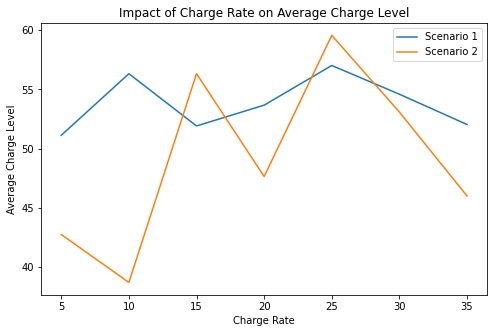

<Figure size 432x288 with 0 Axes>

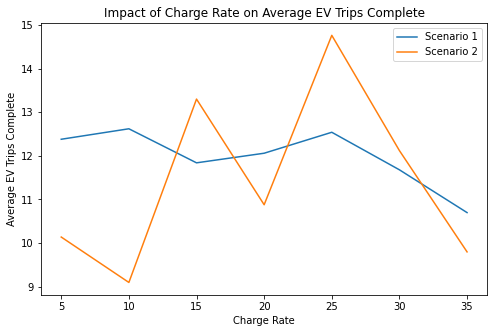

<Figure size 432x288 with 0 Axes>

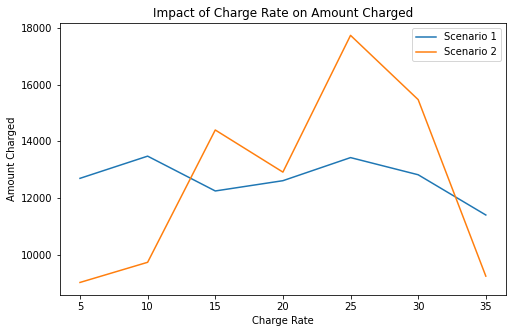

<Figure size 432x288 with 0 Axes>

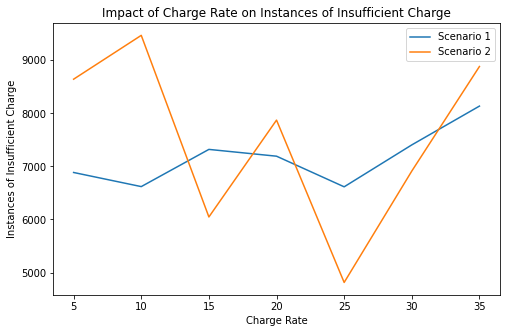

<Figure size 432x288 with 0 Axes>

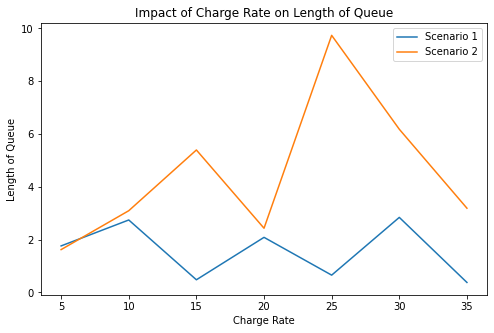

<Figure size 432x288 with 0 Axes>

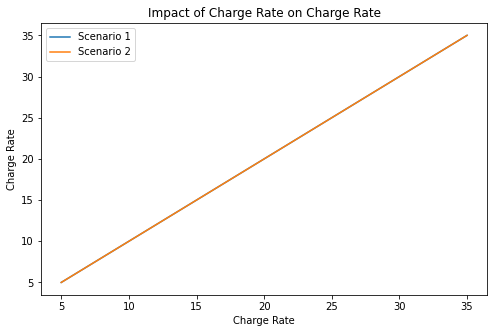

<Figure size 432x288 with 0 Axes>

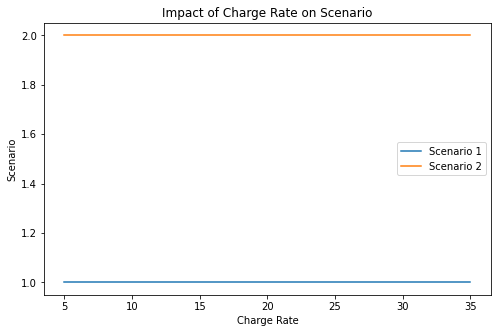

<Figure size 432x288 with 0 Axes>

In [22]:
plot_sensitivity_analysis("Charge Rate", df)

In [42]:
#communte time source: https://www.destatis.de/EN/Themes/Labour/Labour-Market/Employment/Tables/commuter-1.html
time_ranges = [(0,10), (10,30), (30,60), (60, 90)]
time_prob = [0.23, 0.499, 0.222, 0.049] 

#distance_ranges = [(0, 5), (5, 10), (10, 25), (25, 50), (50, 70)] 
#distance_prob = [26.6, 21.8, 29.1, 14.1, 5] 

index = np.random.choice(np.arange(4), p=time_prob)

In [43]:
random.randrange(time_ranges[index][0], time_ranges[index][1])

11